In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,LayerNormalization,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input,MultiHeadAttention,Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [ ]:
tf.__version__

'2.8.2'

# Data Preparation

## Data Download

In [ ]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2022-09-13 16:17:47--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6720195 (6.4M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   6.41M  15.2MB/s    in 0.4s    

2022-09-13 16:17:48 (15.2 MB/s) - ‘fra-eng.zip’ saved [6720195/6720195]



In [ ]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
  inflating: /content/dataset/_about.txt  
  inflating: /content/dataset/fra.txt  


## Kaggle Dataset

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d dhruvildave/en-fr-translation-dataset

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip "/content/en-fr-translation-dataset.zip" -d "/content/dataset/"

Archive:  /content/en-fr-translation-dataset.zip
  inflating: /content/dataset/en-fr.csv  


In [ ]:
dataset = tf.data.experimental.CsvDataset(
  "/content/dataset/en-fr.csv",
  [
    tf.string,
    tf.string
  ],
)

## Data Processing

In [ ]:
text_dataset=tf.data.TextLineDataset("/content/dataset/fra.txt")

In [ ]:
VOCAB_SIZE=20000
ENGLISH_SEQUENCE_LENGTH=64
FRENCH_SEQUENCE_LENGTH=64
EMBEDDING_DIM=256
BATCH_SIZE=64

In [ ]:
english_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [ ]:
french_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [ ]:
def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [ ]:
split_dataset=text_dataset.map(selector)

In [ ]:
def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [ ]:
init_dataset=text_dataset.map(separator)

In [ ]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [ ]:
english_training_data=init_dataset.map(lambda x,y:x)### input x,y and output x
english_vectorize_layer.adapt(english_training_data)#### adapt the vectorize_layer to the training data

In [ ]:
french_training_data=init_dataset.map(lambda x,y:y)### input x,y and output y
french_vectorize_layer.adapt(french_training_data)#### adapt the vectorize_layer to the training data

In [ ]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [ ]:
split_dataset

<MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
dataset=split_dataset.map(vectorizer)

In [ ]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [ ]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[44,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  2, 112,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[112,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,

In [ ]:
dataset

<MapDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [ ]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
dataset

<PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [ ]:
NUM_BATCHES=int(200000/BATCH_SIZE)

In [ ]:
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

In [ ]:
train_dataset

<TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [ ]:
#score=tf.einsum('ijk,ibk->ijb',query,key)

# Modeling

## Embedding

In [ ]:
def positional_encoding(model_size,SEQUENCE_LENGTH):
  output=[]
  for pos in range(SEQUENCE_LENGTH):
    PE=np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i]=np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i]=np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  out=tf.expand_dims(out,axis=0)
  return tf.cast(out,dtype=tf.float32)

In [ ]:
print(positional_encoding(256,64).shape)

(1, 64, 256)


In [ ]:
class Embeddings(Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim,):
    super(Embeddings, self).__init__()
    self.token_embeddings=Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions=positional_encoding(
        self.embed_dim,self.sequence_length)
    return embedded_tokens + embedded_positions
    
  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

In [ ]:
test_input=tf.constant([[  2, 112,   10,   12,  5,   0,   0,   0,]])

emb=Embeddings(8,20000,256)
emb_out=emb(test_input)
print(emb_out.shape)

(1, 8, 256)


In [ ]:
mask=emb.compute_mask(test_input)
mask1 = mask[:, :, tf.newaxis]
mask2 = mask[:,tf.newaxis, :]
padding_mask = tf.cast(mask1&mask2, dtype="int32")
print(1-padding_mask)

tf.Tensor(
[[[0 0 0 0 0 1 1 1]
  [0 0 0 0 0 1 1 1]
  [0 0 0 0 0 1 1 1]
  [0 0 0 0 0 1 1 1]
  [0 0 0 0 0 1 1 1]
  [1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1]]], shape=(1, 8, 8), dtype=int32)


## Custom MultiHeadAttention

In [ ]:
class CustomSelfAttention(Layer):
  def __init__(self,model_size):
    super(CustomSelfAttention,self).__init__()
    self.model_size=model_size
  def call(self,query,key,value,masking):
    ######## compute scores
    score=tf.matmul(query,key,transpose_b=True)
    ######## scaling
    score/=tf.math.sqrt(tf.cast(self.model_size,tf.float32))
    ######## masking
    masking=tf.cast(masking,dtype=tf.float32)
    score+=(1.-masking)*-1e10
    ######## attention_weights
    attention=tf.nn.softmax(score,axis=-1)*masking
    ######## output
    head=tf.matmul(attention,value)
    return head

In [ ]:
attention=CustomSelfAttention(256)
attention(tf.ones([1,8,256]),tf.ones([1,8,256]),tf.ones([1,8,256]),padding_mask)

<tf.Tensor: shape=(1, 8, 256), dtype=float32, numpy=
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [ ]:
class CustomMultiHeadAttention(Layer):
  def __init__(self,num_heads,key_dim):
    super(CustomMultiHeadAttention,self).__init__()
    
    self.num_heads=num_heads
    self.dense_q=[Dense(key_dim) for _ in range(num_heads)]
    self.dense_k=[Dense(key_dim) for _ in range(num_heads)]
    self.dense_v=[Dense(key_dim) for _ in range(num_heads)]
    self.dense_o=Dense(key_dim)
    self.self_attention=CustomSelfAttention(key_dim)
    
  def call(self,query,key,value,attention_mask):
    heads=[]
    
    for i in range(self.num_heads):
        head=self.self_attention(self.dense_q[i](query),self.dense_k[i](key),
                                self.dense_v[i](value),attention_mask)
        heads.append(head)
    heads=tf.concat(heads,axis=2)
    heads=self.dense_o(heads)
    return heads

## Encoder

In [ ]:
#?tf.keras.layers.MultiHeadAttention

In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads,):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,
        )
        self.dense_proj=tf.keras.Sequential(
            [Dense(dense_dim, activation="relu"),Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
      if mask is not None:
        mask1 = mask[:, :, tf.newaxis]
        mask2 = mask[:,tf.newaxis, :]
        padding_mask = tf.cast(mask1&mask2, dtype="int32")

      attention_output = self.attention(
          query=inputs, key=inputs,value=inputs,attention_mask=padding_mask
      )
      
      proj_input = self.layernorm_1(inputs + attention_output)
      proj_output = self.dense_proj(proj_input)
      return self.layernorm_2(proj_input + proj_output)

In [ ]:
encoder_outputs = TransformerEncoder(256,2048,2)(emb_out)
print(encoder_outputs.shape)


(1, 8, 256)


## Decoder

In [ ]:
class TransformerDecoder(Layer):
  def __init__(self, embed_dim, latent_dim, num_heads,):
    super(TransformerDecoder, self).__init__()
    self.embed_dim = embed_dim
    self.latent_dim = latent_dim
    self.num_heads = num_heads
    self.attention_1=MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.attention_2=MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.dense_proj = tf.keras.Sequential(
        [Dense(latent_dim, activation="relu"),Dense(embed_dim),]
    )
    self.layernorm_1=LayerNormalization()
    self.layernorm_2=LayerNormalization()
    self.layernorm_3=LayerNormalization()
    self.supports_masking = True
  def call(self, inputs, encoder_outputs, mask=None):
    
    if mask is not None:
      mask1 = mask[:, :, tf.newaxis]
      mask2 = mask[:,tf.newaxis, :]
      padding_mask = tf.cast(mask1&mask2, dtype="int32")
      causal_mask=tf.linalg.band_part(tf.ones([tf.shape(inputs)[0],tf.shape(inputs)[1],
                                               tf.shape(inputs)[1]],dtype=tf.int32),-1,0)
      combined_mask=tf.minimum(padding_mask,causal_mask)

    attention_output_1 = self.attention_1(
        query=inputs,key=inputs,value=inputs,
        attention_mask=causal_mask,
        
    )
    out_1 = self.layernorm_1(inputs + attention_output_1)

    attention_output_2,scores= self.attention_2(
        query=out_1,key=encoder_outputs,value=encoder_outputs,
        attention_mask=combined_mask,
        return_attention_scores=True
    )
    out_2 = self.layernorm_2(out_1 + attention_output_2)

    proj_output = self.dense_proj(out_2)
    return self.layernorm_3(out_2 + proj_output),scores

In [ ]:
decoder_outputs,scores = TransformerDecoder(256,2048,4)(emb_out,encoder_outputs)
print(decoder_outputs.shape)
print(scores.shape)

(1, 8, 256)
(1, 4, 8, 8)


## Transformer Model

In [ ]:
EMBEDDING_DIM=128
D_FF=1024
NUM_HEADS=8
NUM_LAYERS=1
NUM_EPOCHS=20
attention_scores={}

In [ ]:
encoder_inputs=Input(shape=(None,), dtype="int64", name="input_1")
x = Embeddings(ENGLISH_SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)(encoder_inputs)

for _ in range(NUM_LAYERS):
  x=TransformerEncoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x)
encoder_outputs=x

decoder_inputs=Input(shape=(None,), dtype="int64", name="input_2")

x = Embeddings(FRENCH_SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)(decoder_inputs)
for i in range(NUM_LAYERS):
  x,scores=TransformerDecoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x, encoder_outputs)
  attention_scores[f'decoder_layer{i+1}_block2']=scores
decoder_outputs=Dense(VOCAB_SIZE, activation="softmax")(x)

attention_score_model= tf.keras.Model(
    [encoder_inputs, decoder_inputs], attention_scores, name="atttention_score_model"
)
transformer = tf.keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embeddings_12 (Embeddings)     (None, 64, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 embeddings_13 (Embeddings)     (None, 64, 128)      2560000     ['input_2[0][0]']                
                                                                                        

# Training

In [ ]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words
        
    def result(self):
        return self.bleu_score/BATCH_SIZE

In [ ]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(2e-4),)
    #metrics=[BLEU()],
    #run_eagerly=True)

In [ ]:
history=transformer.fit(
    train_dataset,
    validation_data=val_dataset.take(300),
    epochs=NUM_EPOCHS)

Epoch 1/20
2812/2812 [==============================] - 170s 59ms/step - loss: 0.4194
Epoch 2/20
2812/2812 [==============================] - 167s 59ms/step - loss: 0.2455
Epoch 3/20
2812/2812 [==============================] - 167s 59ms/step - loss: 0.1820
Epoch 4/20
 470/2812 [====>.........................] - ETA: 2:19 - loss: 0.1041

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
transformer.evaluate(val_dataset)

# Testing

In [ ]:
index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [ ]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output=transformer.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [ ]:
translator('What makes you think that it is not true?')

'questce qui te fait croire que ce nest pas vrai'

In [ ]:
translator('Have you ever watched soccer under the rain?')

'astu regardé français à luniversité sous la pluie'

In [ ]:
translator("what's your name?")

'comment se nomme ton nom'

In [ ]:
translator('Great trees do not grow with ease, the stronger the winds, the stronger the trees')

'les arbres ne font plus pousser sur les autres'

In [ ]:
translator('My hotel told me to call you. ')

'mon hôtel ma dit de mappeler'

In [ ]:
translator('His French is improving little by little')

'son français saméliore petit'

In [ ]:
translator('I love to write')

'jadore écrire à écrire'

In [ ]:
translator('Perhaps she will come tomorrow')

'peutêtre quelle viendra demain'

In [ ]:
translator('Tom has never heard Mary sing.')

'tom na jamais entendu marie chanter'

In [ ]:
translator('She handed him the money')

'elle lui donna largent'

# Visualization

In [ ]:
def visualize(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken je lai fait très bien'

  tokenized_shifted_target=french_vectorize_layer([shifted_target])
  attention_weights=attention_score_model.predict([tokenized_english_sentence,
                                                   tokenized_shifted_target])
    
  return attention_weights

out=visualize('I did it very well')


In [ ]:
print(out['decoder_layer1_block2'][0].shape)

(8, 64, 64)


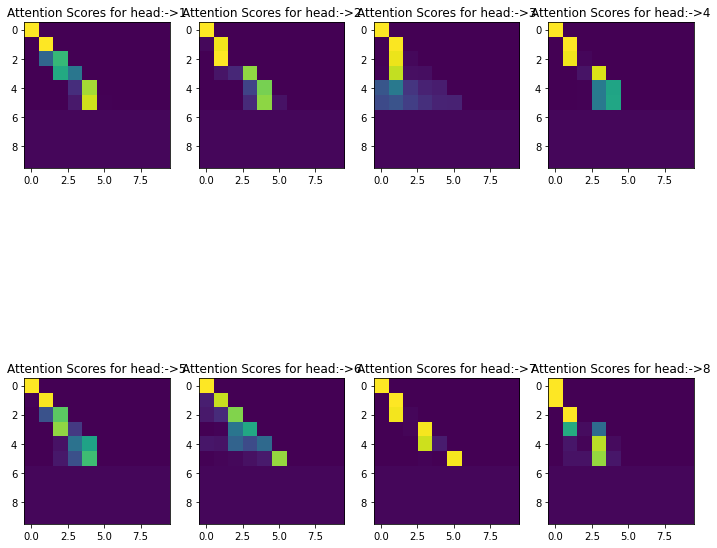

In [ ]:
plt.figure(figsize = (12,12))

for i in range(NUM_HEADS):
  ax = plt.subplot(2,4, i+1)
  
  plt.imshow(out['decoder_layer1_block2'][0][i][0:10,0:10])
  plt.title("Attention Scores for head:->"+str(i+1))

In [ ]:
!pip install aicrowd-cli

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 4.0 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 1.1 MB 44.1 MB/s 
     |████████████████████████████████| 170 kB 72.7 MB/s 
     |████████████████████████████████| 214 kB 61.2 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 51 kB 7.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 23.2.1
    Uninstalling pyzmq-23.2.1:
      Successfully uninstalled pyzmq-23.2.1
  Attempting uninstall: python-slugify
    Found existing installation: python-slugify 6.1.2
    Uninstalling python-slugify-6.1.2:
 

In [ ]:
!aicrowd login

Please login here: https://api.aicrowd.com/auth/wtHm9oiaN9-I--I4Ivn1eRDGXB7IG6YYX1nlj37hllk
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://api.aicrowd.com/auth/wtHm9oiaN9-I--I4Ivn1eRDGXB7IG6YYX1nlj37hllk'
API Key valid
Gitlab access token valid
Saved details successfully!


In [ ]:
!aicrowd dataset download -c esci-challenge-for-improving-product-search

product_catalogue-v0.3.csv.zip: 100% 328M/328M [00:16<00:00, 20.1MB/s]
sample_submission_public-v0.3.csv.zip: 100% 331k/331k [00:00<00:00, 587kB/s]
test_public-v0.3.csv.zip: 100% 394k/394k [00:00<00:00, 690kB/s]
train-v0.3.csv.zip: 100% 6.80M/6.80M [00:01<00:00, 5.95MB/s]
product_catalogue-v0.3.csv.zip: 100% 657M/657M [00:31<00:00, 21.1MB/s]
sample_submission_public-v0.3.csv.zip: 100% 812k/812k [00:00<00:00, 1.15MB/s]
test_public-v0.3.csv.zip: 100% 2.94M/2.94M [00:01<00:00, 2.94MB/s]
train-v0.3.csv.zip: 100% 19.8M/19.8M [00:01<00:00, 11.4MB/s]
product_catalogue-v0.3.csv.zip: 100% 657M/657M [00:42<00:00, 15.5MB/s]
sample_submission_public-v0.3.csv.zip: 100% 803k/803k [00:00<00:00, 1.12MB/s]
test_public-v0.3.csv.zip: 100% 2.94M/2.94M [00:00<00:00, 2.97MB/s]
train-v0.3.csv.zip: 100% 20.3M/20.3M [00:01<00:00, 10.9MB/s]


In [ ]:
!unzip "/content/product_catalogue-v0.3.csv.zip" -d "/content/dataset/"

Archive:  /content/product_catalogue-v0.3.csv.zip
  inflating: /content/dataset/data/processed/public/task_3_product_substitute_identification/product_catalogue-v0.3.csv  


In [ ]:
filepath='/content/dataset/data/processed/public/task_3_product_substitute_identification/product_catalogue-v0.3.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(filepath)


In [ ]:
len(df)

1815216

In [ ]:
df[1600000:1600050]

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color_name,product_locale
1600000,B07RK154DV,"Stemless Wine Tumbler with Lid and Straw, Bast...",<b>Bastwe 4 Pack 12oz Vacuum Insulated Wine Tu...,💥 Food Grade Stainless Steel: The wine glass i...,Bastwe,Black,us
1600001,B07T3SLJQ7,PURECUP 12 oz Wine Tumbler With Spill-proof Li...,<b>Specification:</b><br>*Designs: Stainless W...,12OZ insulated stainless stell wine glasses wi...,PURECUP,Aqua Blue,us
1600002,B07TF6JXSG,Comfook Glass Bulk Set Wine Cups Glasses with ...,NaN,For Any Occasion: 12 oz glass is in a beautifu...,Comfook,Multicolor B,us
1600003,B07VH1XG7J,Deitybless 6 Pack 12 oz Stainless Steel Wine T...,Deitybless pack wine tumbler cup with lids 12 ...,【HIGHT QUALITY】The wine tumbler is made of goo...,Deitybless,Assorted Colors_6 pack(with straws),us
1600004,B0822R1N1K,Vacuum Insulated Wine Tumbler with Sliding Lid...,<b>LEVIN Vacuum Insulated Wine Tumbler with Sl...,【Preserve the Most Wanted Temp & Flavour】 Adop...,LEVIN,Black,us
1600005,B082SC54BP,MUCHENGHY 12 oz Wine Glass Tumbler Bulk with L...,<p>Mucheng Vacuum Insulated Wine Tumbler with ...,【GIVE AS A PRESENT TO COMMEMORATE!】 It's strik...,MUCHENGHY,Rose Gold,us
1600006,B01M71BZD9,Yedi 9-in-1 Total Package Instant Programmable...,NaN,OPRAH’S FAVORITE THINGS: The Yedi 9-in-1 Total...,YEDI HOUSEWARE,Stainless Steel,us
1600007,B01NBKTPTS,Instant Pot Duo Plus 6 Quart 9-in-1 Electric P...,NaN,"SIMPLE, STRESS-FREE VENTING with an intuitive ...",Instant Pot,Stainless Steel/Black,us
1600008,B0777XQ4S8,Instant Pot Smart Wifi 6 Quart Multi-use Elect...,NaN,Cooks fast and saves time: The Instant Pot Sma...,Instant Pot,Silver,us
1600009,B077T9YGRM,Instant Pot Max 6 Quart Multi-use Electric Pre...,NaN,"Sustained 15psi, not only cooks food faster, y...",Instant Pot,Silver,us


In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self,transformer):
    super(Transformer,self).__init__()
    self.transformer=transformer
    
  def compile(self,loss_fn,optimizer):
    super(Transformer,self).compile()
    self.optimizer=optimizer
    self.loss_fn=loss_fn
    self.loss_metric=tf.keras.metrics.Mean(name='loss')
    
  @property
  def metrics(self):
    return [self.loss_metric,]

  def train_step(self,x_y):
    inputs,target=x_y
    encoder_input=inputs['input_1']
    shifted_target=inputs['input_2']

    with tf.GradientTape() as recorder:

      output,_=self.transformer([encoder_input,shifted_target])
      loss=self.loss_fn(target,output)
      
    partial_derivatives = recorder.gradient(loss,self.transformer.trainable_weights)
    self.optimizer.apply_gradients(zip(partial_derivatives, self.transformer.trainable_weights))

    self.loss_metric.update_state(loss)
    
    return {'loss':self.loss_metric.result()}